In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.font_manager as fm
from collections import Counter
import seaborn as sns
import time
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
wandb.login(key="f659082c2b19bf3ffaaceceb36c1e280541f6b11")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yeshu183 (yeshu183-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
class tsvtokenizer(Dataset):
    def __init__(self, tsv_file, src_vocab=None, tgt_vocab=None, max_len=32, build_vocab=False):
        # Read TSV file - the fields are separated by tabs, and we're interested in the first two columns
        # Each line has: native_text, roman_text, frequency
        try:
            df = pd.read_csv(tsv_file, sep='\t', header=None, 
                             names=['native', 'roman', 'freq'], 
                             usecols=[0, 1], dtype=str)
            print(f"Successfully loaded {len(df)} entries from {tsv_file}")
            
            # Fill NA values to prevent errors
            df['native'] = df['native'].fillna('')
            df['roman'] = df['roman'].fillna('')
            
            # Create pairs of (roman, native) for transliteration
            self.pairs = list(zip(df['roman'], df['native']))
            print(f"Sample data: {self.pairs[:2]}")
        except Exception as e:
            print(f"Error loading dataset: {e}")
            # Create an empty dataset as fallback
            self.pairs = [('', '')]
            
        self.max_len = max_len
        # Build or use provided vocabulary
        if build_vocab:
            # Start vocabulary with special tokens including <sos> and <eos>
            self.src_vocab = {'<pad>': 0, '<unk>': 1, '<sos>': 2, '<eos>': 3}
            self.tgt_vocab = {'<pad>': 0, '<unk>': 1, '<sos>': 2, '<eos>': 3}
            self._build_vocab()
        else:
            self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
            
    def _build_vocab(self):
        # Build character-level vocabulary from the dataset
        for src, tgt in self.pairs:
            for ch in src:
                if ch not in self.src_vocab: 
                    self.src_vocab[ch] = len(self.src_vocab)
            for ch in tgt:
                if ch not in self.tgt_vocab: 
                    self.tgt_vocab[ch] = len(self.tgt_vocab)
        print(f"Built vocabularies - Source: {len(self.src_vocab)}, Target: {len(self.tgt_vocab)}")
    
    def __len__(self): 
        return len(self.pairs)
    
    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        # Convert characters to indices with bounds checking and add start/end tokens
        # Source sequence (input)
        src_idxs = [self.src_vocab['<sos>']]  # Start token
        for ch in src:
            idx = self.src_vocab.get(ch, self.src_vocab['<unk>'])
            if idx >= len(self.src_vocab):
                idx = self.src_vocab['<unk>']  # Safety check
            src_idxs.append(idx)
        src_idxs.append(self.src_vocab['<eos>'])  # End token
            
        # Target sequence (output)
        tgt_idxs = [self.tgt_vocab['<sos>']]  # Start token
        for ch in tgt:
            idx = self.tgt_vocab.get(ch, self.tgt_vocab['<unk>'])
            if idx >= len(self.tgt_vocab):
                idx = self.tgt_vocab['<unk>']  # Safety check
            tgt_idxs.append(idx)
        tgt_idxs.append(self.tgt_vocab['<eos>'])  # End token
        
        # Make sure we don't exceed max_len (accounting for <sos> and <eos> tokens)
        if len(src_idxs) > self.max_len:
            # Keep <sos>, truncate middle, and keep <eos>
            src_idxs = [src_idxs[0]] + src_idxs[1:self.max_len-1] + [src_idxs[-1]]
        if len(tgt_idxs) > self.max_len:
            # Keep <sos>, truncate middle, and keep <eos>
            tgt_idxs = [tgt_idxs[0]] + tgt_idxs[1:self.max_len-1] + [tgt_idxs[-1]]
        
        # Add padding
        pad_src = [self.src_vocab['<pad>']] * (self.max_len - len(src_idxs))
        pad_tgt = [self.tgt_vocab['<pad>']] * (self.max_len - len(tgt_idxs))
        
        # Combine with padding
        src_idxs = src_idxs + pad_src
        tgt_idxs = tgt_idxs + pad_tgt
        
        # Make sure padding index is valid
        assert self.src_vocab['<pad>'] < len(self.src_vocab), "Padding index out of bounds for source vocab"
        assert self.tgt_vocab['<pad>'] < len(self.tgt_vocab), "Padding index out of bounds for target vocab"
        
        return torch.tensor(src_idxs, dtype=torch.long), torch.tensor(tgt_idxs, dtype=torch.long)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs):
        # hidden: [batch_size, hidden_dim]
        # encoder_outputs: [batch_size, src_len, hidden_dim]
        
        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)
        
        # Repeat hidden to match encoder outputs dimensions for concatenation
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Calculate energy
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy: [batch_size, src_len, hidden_dim]
        
        attention = self.v(energy).squeeze(2)
        # attention: [batch_size, src_len]
        
        # Apply softmax to get attention weights
        return F.softmax(attention, dim=1)

class AttentionSeq2Seq(nn.Module):
    def __init__(self, cfg, src_vocab_size, tgt_vocab_size):
        super().__init__()
        # Make sure vocab sizes are valid
        assert src_vocab_size > 0, f"Invalid source vocabulary size: {src_vocab_size}"
        assert tgt_vocab_size > 0, f"Invalid target vocabulary size: {tgt_vocab_size}"
        
        # Define model hyperparameters
        self.embed_dim = cfg.embed_dim
        self.hidden_dim = cfg.hidden_dim
        self.cell_type = cfg.cell_type
        self.enc_layers = cfg.enc_layers
        self.dec_layers = cfg.dec_layers
        
        # Initialize embeddings
        self.src_emb = nn.Embedding(src_vocab_size, cfg.embed_dim, padding_idx=0)
        self.tgt_emb = nn.Embedding(tgt_vocab_size, cfg.embed_dim, padding_idx=0)
        
        # Cell type selection
        if cfg.cell_type == 'RNN':
            cell = nn.RNN
        elif cfg.cell_type == 'GRU':
            cell = nn.GRU
        elif cfg.cell_type == 'LSTM':
            cell = nn.LSTM
        else:
            raise ValueError(f"Unsupported cell type: {cfg.cell_type}")
        
        # Define dropout rates
        enc_dr = cfg.dropout if cfg.enc_layers > 1 else 0.0
        dec_dr = cfg.dropout if cfg.dec_layers > 1 else 0.0
        
        # Initialize encoder and decoder
        self.encoder = cell(cfg.embed_dim, cfg.hidden_dim,
                          num_layers=cfg.enc_layers, batch_first=True, dropout=enc_dr)
        
        # Decoder input will be the concatenation of embedding and context vector
        self.decoder = cell(cfg.embed_dim + cfg.hidden_dim, cfg.hidden_dim,
                          num_layers=cfg.dec_layers, batch_first=True, dropout=dec_dr)
        
        # Attention mechanism
        self.attention = Attention(cfg.hidden_dim)
        
        # Output projection - using hidden state and context for prediction
        self.fc = nn.Linear(cfg.hidden_dim * 2, tgt_vocab_size)
        
        print(f"Attention Model initialized: {cfg.cell_type} with {cfg.enc_layers} encoder layers, "
              f"{cfg.dec_layers} decoder layers, {cfg.embed_dim} embedding dim, "
              f"{cfg.hidden_dim} hidden dim")

    def forward(self, src, tgt):
        batch_size = src.size(0)
        src_len = src.size(1)
        tgt_len = tgt.size(1)
        device = src.device
        
        # Check for out of bounds indices
        if src.max() >= self.src_emb.num_embeddings:
            print(f"Warning: Source index {src.max().item()} is out of bounds for vocab size {self.src_emb.num_embeddings}")
            # Clamp indices to valid range
            src = torch.clamp(src, 0, self.src_emb.num_embeddings - 1)
        
        if tgt.max() >= self.tgt_emb.num_embeddings:
            print(f"Warning: Target index {tgt.max().item()} is out of bounds for vocab size {self.tgt_emb.num_embeddings}")
            # Clamp indices to valid range
            tgt = torch.clamp(tgt, 0, self.tgt_emb.num_embeddings - 1)
        
        # Forward through encoder
        enc_in = self.src_emb(src)
        
        try:
            # Store all encoder outputs for attention
            if self.cell_type == 'LSTM':
                encoder_outputs, (h_n, c_n) = self.encoder(enc_in)
                
                # Adapt hidden state dimensions for different layer counts
                if self.enc_layers != self.dec_layers:
                    # Initialize new hidden and cell states with correct dimensions
                    h_new = torch.zeros(self.dec_layers, batch_size, self.hidden_dim, device=device)
                    c_new = torch.zeros(self.dec_layers, batch_size, self.hidden_dim, device=device)
                    # Copy as many layers as possible
                    copy_layers = min(self.enc_layers, self.dec_layers)
                    h_new[:copy_layers] = h_n[:copy_layers]
                    c_new[:copy_layers] = c_n[:copy_layers]
                    
                    h_n, c_n = h_new, c_new
                
                # Initialize output tensor - one less than target length because we don't need to predict after EOS
                outputs = torch.zeros(batch_size, tgt_len-1, self.tgt_emb.num_embeddings, device=device)
                
                # Get the last hidden state for attention
                hidden = h_n[-1]
                
                # Decode one step at a time with attention
                for t in range(tgt_len-1):
                    # Get embedding of current input token
                    dec_in_t = self.tgt_emb(tgt[:, t]).unsqueeze(1)  # [batch_size, 1, embed_dim]
                    
                    # Calculate attention weights
                    attn_weights = self.attention(hidden, encoder_outputs)  # [batch_size, src_len]
                    
                    # Apply attention weights to encoder outputs
                    context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # [batch_size, 1, hidden_dim]
                    
                    # Concatenate context with input embedding
                    rnn_input = torch.cat((dec_in_t, context), dim=2)  # [batch_size, 1, embed_dim + hidden_dim]
                    
                    # Forward through decoder
                    dec_out, (h_n, c_n) = self.decoder(rnn_input, (h_n, c_n))
                    
                    # Update hidden for next attention calculation
                    hidden = h_n[-1]
                    
                    # Concatenate decoder output with context for prediction
                    output = torch.cat((dec_out.squeeze(1), context.squeeze(1)), dim=1)
                    
                    # Project to vocabulary size
                    prediction = self.fc(output)
                    
                    # Store prediction
                    outputs[:, t] = prediction
                
                return outputs
                
            else:  # RNN or GRU
                encoder_outputs, h_n = self.encoder(enc_in)
                
                # Adapt hidden state dimensions for different layer counts
                if self.enc_layers != self.dec_layers:
                    h_new = torch.zeros(self.dec_layers, batch_size, self.hidden_dim, device=device)
                    copy_layers = min(self.enc_layers, self.dec_layers)
                    h_new[:copy_layers] = h_n[:copy_layers]
                    h_n = h_new
                
                # Initialize output tensor - one less than target length because we don't need to predict after EOS
                outputs = torch.zeros(batch_size, tgt_len-1, self.tgt_emb.num_embeddings, device=device)
                
                # Get the last hidden state for attention
                hidden = h_n[-1]
                
                # Decode one step at a time with attention
                for t in range(tgt_len-1):
                    # Get embedding of current input token
                    dec_in_t = self.tgt_emb(tgt[:, t]).unsqueeze(1)  # [batch_size, 1, embed_dim]
                    
                    # Calculate attention weights
                    attn_weights = self.attention(hidden, encoder_outputs)  # [batch_size, src_len]
                    
                    # Apply attention weights to encoder outputs
                    context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # [batch_size, 1, hidden_dim]
                    
                    # Concatenate context with input embedding
                    rnn_input = torch.cat((dec_in_t, context), dim=2)  # [batch_size, 1, embed_dim + hidden_dim]
                    
                    # Forward through decoder
                    dec_out, h_n = self.decoder(rnn_input, h_n)
                    
                    # Update hidden for next attention calculation
                    hidden = h_n[-1]
                    
                    # Concatenate decoder output with context for prediction
                    output = torch.cat((dec_out.squeeze(1), context.squeeze(1)), dim=1)
                    
                    # Project to vocabulary size
                    prediction = self.fc(output)
                    
                    # Store prediction
                    outputs[:, t] = prediction
                
                return outputs
            
        except Exception as e:
            print(f"Error in forward pass: {e}")
            # Return dummy tensor on error
            return torch.zeros(batch_size, tgt_len-1, self.tgt_emb.num_embeddings, device=device)

In [5]:
def generate_with_attention(model, src, max_len=32, eos_idx=3, sos_idx=2, device="cuda"):
    """
    Generate target sequence using greedy decoding with attention.
    
    Args:
        model: Trained AttentionSeq2Seq model
        src: Source sequence tensor [batch_size, seq_len]
        max_len: Maximum length of generated sequence
        eos_idx: Index of <eos> token in target vocabulary
        sos_idx: Index of <sos> token in target vocabulary
        device: Device to run inference on
    
    Returns:
        List of generated sequences and attention weights
    """
    model.eval()  # Set model to evaluation mode
    batch_size = src.size(0)
    
    with torch.no_grad():
        # Encode source sequence
        enc_in = model.src_emb(src)
        
        if model.cell_type == 'LSTM':
            encoder_outputs, (h_n, c_n) = model.encoder(enc_in)
            
            # Adapt hidden state dimensions for decoder if needed
            if model.enc_layers != model.dec_layers:
                h_new = torch.zeros(model.dec_layers, batch_size, model.hidden_dim, device=device)
                c_new = torch.zeros(model.dec_layers, batch_size, model.hidden_dim, device=device)
                copy_layers = min(model.enc_layers, model.dec_layers)
                h_new[:copy_layers] = h_n[:copy_layers]
                c_new[:copy_layers] = c_n[:copy_layers]
                h_n, c_n = h_new, c_new
            
            hidden = h_n[-1]  # Last hidden state for attention
            hidden_state = (h_n, c_n)  # Full hidden state for decoder
        else:  # RNN or GRU
            encoder_outputs, h_n = model.encoder(enc_in)
            
            # Adapt hidden state dimensions for decoder if needed
            if model.enc_layers != model.dec_layers:
                h_new = torch.zeros(model.dec_layers, batch_size, model.hidden_dim, device=device)
                copy_layers = min(model.enc_layers, model.dec_layers)
                h_new[:copy_layers] = h_n[:copy_layers]
                h_n = h_new
            
            hidden = h_n[-1]  # Last hidden state for attention
            hidden_state = h_n  # Full hidden state for decoder
        
        # Start with <sos> tokens for each sequence in batch
        current_token = torch.full((batch_size, 1), sos_idx, dtype=torch.long, device=device)
        
        # Store generated sequences
        generated_sequences = torch.zeros(batch_size, max_len, dtype=torch.long, device=device)
        generated_sequences[:, 0] = sos_idx
        
        # Store attention weights for visualization
        attention_weights = torch.zeros(batch_size, max_len-1, src.size(1), device=device)
        
        # Track if sequence is completed (has generated EOS)
        completed = torch.zeros(batch_size, dtype=torch.bool, device=device)
        
        # Generate one token at a time
        for i in range(1, max_len):
            # Embed current token
            dec_in = model.tgt_emb(current_token)
            
            # Calculate attention weights
            attn_weights = model.attention(hidden, encoder_outputs)  # [batch_size, src_len]
            attention_weights[:, i-1] = attn_weights
            
            # Apply attention weights to encoder outputs
            context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # [batch_size, 1, hidden_dim]
            
            # Concatenate context with input embedding
            rnn_input = torch.cat((dec_in, context), dim=2)  # [batch_size, 1, embed_dim + hidden_dim]
            
            # Pass through decoder
            if model.cell_type == 'LSTM':
                dec_out, hidden_state = model.decoder(rnn_input, hidden_state)
                hidden = hidden_state[0][-1]  # Update hidden for next attention calculation
            else:
                dec_out, hidden_state = model.decoder(rnn_input, hidden_state)
                hidden = hidden_state[-1]  # Update hidden for next attention calculation
            
            # Concatenate decoder output with context for prediction
            output = torch.cat((dec_out.squeeze(1), context.squeeze(1)), dim=1)
            
            # Get output probabilities and select most likely token
            logits = model.fc(output)
            probs = F.softmax(logits, dim=-1)
            next_token = torch.argmax(probs, dim=-1).unsqueeze(1)
            
            # Store token in output sequence
            generated_sequences[:, i] = next_token.squeeze(1)
            
            # Mark sequences that generated EOS
            completed = completed | (next_token.squeeze(1) == eos_idx)
            
            # Stop if all sequences have generated EOS
            if completed.all():
                break
            
            # Update current token for next iteration
            current_token = next_token
        
        # Post-process sequences - ensure all have EOS and nothing after
        for b in range(batch_size):
            # Find first EOS token (if any)
            eos_positions = (generated_sequences[b] == eos_idx).nonzero(as_tuple=True)[0]
            
            if len(eos_positions) > 0:
                # Get the position of the first EOS
                first_eos = eos_positions[0].item()
                
                # If EOS isn't the last token, zero out everything after it
                if first_eos < max_len - 1:
                    generated_sequences[b, first_eos+1:] = 0
            else:
                # If no EOS found, append it at the end
                generated_sequences[b, -1] = eos_idx
        
        return generated_sequences, attention_weights

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

def plot_attention_heatmap(source_text, target_text, attention_weights, idx_to_src, idx_to_tgt, hindi_font, save_path=None):
    """
    Plot attention heatmap for a single example.
    
    Args:
        source_text: Source text as a list of characters
        target_text: Target text as a list of characters
        attention_weights: Attention weights tensor [target_len, source_len]
        idx_to_src: Dictionary mapping indices to source characters
        idx_to_tgt: Dictionary mapping indices to target characters
        hindi_font: Font for displaying Hindi characters
        save_path: Path to save the figure (optional)
    """
    # Convert attention weights to numpy array
    attention = attention_weights.cpu().numpy()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot heatmap
    cax = ax.matshow(attention, cmap='viridis')
    
    # Set axis labels
    ax.set_xticklabels([''] + source_text, rotation=90, fontproperties=hindi_font)
    ax.set_yticklabels([''] + target_text, fontproperties=hindi_font)
    
    # Add colorbar
    fig.colorbar(cax)
    
    # Set title
    plt.title(f"Attention Heatmap: {''.join(source_text)} → {''.join(target_text)}", fontproperties=hindi_font)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

def plot_attention_grid(examples, attention_weights, src_vocab, tgt_vocab, hindi_font, save_path=None):
    """
    Plot a grid of attention heatmaps.
    
    Args:
        examples: List of dictionaries with source, target, and prediction
        attention_weights: List of attention weight tensors
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        hindi_font: Font for displaying Hindi characters
        save_path: Path to save the figure (optional)
    """
    # Create reverse mappings
    idx_to_src = {idx: char for char, idx in src_vocab.items()}
    idx_to_tgt = {idx: char for char, idx in tgt_vocab.items()}
    
    # Determine grid size
    n = len(examples)
    rows = int(np.ceil(np.sqrt(n)))
    cols = int(np.ceil(n / rows))
    
    # Create figure
    fig = plt.figure(figsize=(cols * 5, rows * 4))
    
    for i, (example, attn) in enumerate(zip(examples, attention_weights)):
        if i >= n:
            break
        
        # Extract source and target text
        source_text = [c for c in example['source']]
        target_text = [c for c in example['prediction']]
        
        # Get attention weights for this example
        # Use only the relevant part of attention weights (up to target length)
        attn_weights = attn[:len(target_text), :len(source_text)]
        
        # Create subplot
        ax = fig.add_subplot(rows, cols, i + 1)
        
        # Plot heatmap
        cax = ax.matshow(attn_weights.cpu().numpy(), cmap='viridis')
        
        # Set axis labels
        ax.set_xticklabels([''] + source_text, rotation=90, fontproperties=hindi_font)
        ax.set_yticklabels([''] + target_text, fontproperties=hindi_font)
        
        # Set title
        ax.set_title(f"{''.join(source_text)} → {''.join(target_text)}", fontproperties=hindi_font)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path)
    
    plt.show()


In [7]:
def train_attention_model(train_tsv, dev_tsv, vocab_path, model_path, epochs=2, max_len=32, early_stop_patience=5):
    """
    Train an attention-based sequence-to-sequence model.
    
    Args:
        train_tsv: Path to the training data
        dev_tsv: Path to the validation data
        vocab_path: Path to save/load vocabulary
        model_path: Path to save the best model
        epochs: Number of epochs to train for
        max_len: Maximum sequence length
        early_stop_patience: Number of epochs to wait without improvement before stopping
    
    Returns:
        model: The trained model
        best_val_loss: The best validation loss achieved
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
    """
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load vocabulary
    try:
        print("Loading saved vocabulary...")
        with open(f"{vocab_path}/src.json", 'r', encoding='utf-8') as f:
            src_vocab = json.load(f)
        with open(f"{vocab_path}/tgt.json", 'r', encoding='utf-8') as f:
            tgt_vocab = json.load(f)
        print("Vocabulary loaded successfully")
    except Exception as e:
        print(f"Error loading vocabulary: {e}")
        print("Building vocabulary from training data...")
        train_dataset = tsvtokenizer(train_tsv, max_len=max_len, build_vocab=True)
        src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
    
    print(f"Vocabulary sizes: Source = {len(src_vocab)}, Target = {len(tgt_vocab)}")
    
    # Initialize wandb
    run = wandb.init(project='DA6401_Assignment_03_Attention', 
                    name='Attention_Model',
                    config={
                        'embed_dim': 64,
                        'hidden_dim': 128,
                        'cell_type': 'LSTM',
                        'enc_layers': 1,
                        'dec_layers': 1,
                        'dropout': 0.2,
                        'learning_rate': 0.001,
                        'batch_size': 64
                    })
    
    cfg = run.config
    
    # Initialize model
    model = AttentionSeq2Seq(cfg, len(src_vocab), len(tgt_vocab)).to(device)
    
    # Load datasets
    print("Loading datasets...")
    train_dataset = tsvtokenizer(train_tsv, src_vocab, tgt_vocab, max_len=max_len)
    dev_dataset = tsvtokenizer(dev_tsv, src_vocab, tgt_vocab, max_len=max_len)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=cfg.batch_size)
    print(f"Loaded {len(train_dataset)} training examples and {len(dev_dataset)} validation examples")
    
    # Initialize loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # 0 is padding index
    optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
    
    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=2, factor=0.5, verbose=True
    )
    
    # Training loop
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training
        model.train()
        train_loss = 0.0
        num_batches = 0
        
        for batch_idx, (src, tgt) in enumerate(train_loader):
            try:
                # Move data to device
                src, tgt = src.to(device), tgt.to(device)
                
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                output = model(src, tgt)
                
                # Reshape for loss calculation
                output_flat = output.reshape(-1, output.size(-1))
                tgt_flat = tgt[:, 1:].reshape(-1)
                
                # Compute loss
                loss = criterion(output_flat, tgt_flat)
                
                # Backpropagation
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                num_batches += 1
                
                if batch_idx % 200 == 0:
                    print(f"  Batch {batch_idx}/{len(train_loader)}: Loss = {loss.item():.4f}")
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue
        
        train_loss /= num_batches if num_batches > 0 else 1
        print(f"Train loss: {train_loss:.4f}")
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for src, tgt in dev_loader:
                try:
                    # Move data to device
                    src, tgt = src.to(device), tgt.to(device)
                    
                    # Forward pass
                    output = model(src, tgt)
                    
                    # Reshape for loss calculation
                    output_flat = output.reshape(-1, output.size(-1))
                    tgt_flat = tgt[:, 1:].reshape(-1)
                    
                    # Compute loss
                    loss = criterion(output_flat, tgt_flat)
                    
                    val_loss += loss.item()
                    val_batches += 1
                    
                except Exception as e:
                    print(f"Error in validation batch: {e}")
                    continue
        
        val_loss /= val_batches if val_batches > 0 else 1
        print(f"Validation loss: {val_loss:.4f}")
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Log metrics
        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'epoch': epoch+1,
            'learning_rate': optimizer.param_groups[0]['lr']
        })
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            
            # Save model
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': {k: v for k, v in cfg.items()},
                'src_vocab_size': len(src_vocab),
                'tgt_vocab_size': len(tgt_vocab),
                'epoch': epoch+1,
                'best_val_loss': best_val_loss,
            }, model_path)
            
            print(f"Saved new best model with validation loss: {val_loss:.4f}")
            
            # Reset patience counter
            patience_counter = 0
        else:
            # Increment patience counter
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"Early stopping triggered after {epoch+1} epochs without improvement")
                break
    
    # Load best model state
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    # Finish wandb run
    wandb.finish()
    
    return model, best_val_loss, src_vocab, tgt_vocab


In [8]:
def evaluate_attention_model(model, test_loader, device, src_vocab, tgt_vocab):
    """
    Evaluate the attention model on test data.
    
    Args:
        model: Trained AttentionSeq2Seq model
        test_loader: DataLoader with test data
        device: Device to run inference on
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
    
    Returns:
        accuracy: Exact match accuracy
        examples: List of examples with attention weights
    """
    model.eval()
    correct = 0
    total = 0
    examples = []
    
    # Create reverse mappings
    idx_to_src = {idx: char for char, idx in src_vocab.items()}
    idx_to_tgt = {idx: char for char, idx in tgt_vocab.items()}
    
    # Special token indices
    eos_idx = tgt_vocab.get('<eos>', 3)
    sos_idx = tgt_vocab.get('<sos>', 2)
    
    with torch.no_grad():
        for src, tgt in test_loader:
            # Move data to device
            src, tgt = src.to(device), tgt.to(device)
            batch_size = src.size(0)
            
            # Generate predictions with attention weights
            predictions, attention_weights = generate_with_attention(
                model,
                src,
                max_len=tgt.size(1),
                eos_idx=eos_idx,
                sos_idx=sos_idx,
                device=device
            )
            
            # Decode sequences
            for i in range(batch_size):
                # Process source sequence
                src_text = ""
                for idx in src[i]:
                    idx = idx.item()
                    if idx == 0:  # Skip padding
                        continue
                    if idx == sos_idx:
                        continue  # Skip <sos>
                    if idx == eos_idx:
                        break  # Stop at <eos>
                    src_text += idx_to_src.get(idx, '')
                
                # Process target sequence
                tgt_text = ""
                for idx in tgt[i, 1:]:  # Skip <sos>
                    idx = idx.item()
                    if idx == 0:  # Skip padding
                        continue
                    if idx == eos_idx:
                        break  # Stop at <eos>
                    tgt_text += idx_to_tgt.get(idx, '')
                
                # Process predicted sequence
                pred_text = ""
                for idx in predictions[i, 1:]:  # Skip <sos>
                    idx = idx.item()
                    if idx == 0:  # Skip padding
                        continue
                    if idx == eos_idx:
                        break  # Stop at <eos>
                    pred_text += idx_to_tgt.get(idx, '')
                
                # Check if prediction is correct
                is_correct = (tgt_text == pred_text)
                if is_correct:
                    correct += 1
                
                # Store example with attention weights
                examples.append({
                    'source': src_text,
                    'target': tgt_text,
                    'prediction': pred_text,
                    'is_correct': is_correct,
                    'attention': attention_weights[i, :len(pred_text), :len(src_text)]
                })
                
                total += 1
    
    accuracy = correct / total if total > 0 else 0
    print(f"Test accuracy: {accuracy:.4f} ({correct}/{total})")
    
    return accuracy, examples


In [9]:
train_tsv = '/kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv'
dev_tsv = '/kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv'
test_tsv = '/kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.test.tsv'
vocab_path = '/kaggle/working/vocab'
attention_model_path = '/kaggle/working/best_attention_model.pt'

In [10]:
# print("Training attention model...")
# attention_model, best_val_loss, src_vocab, tgt_vocab = train_attention_model(
#     train_tsv, dev_tsv, vocab_path, attention_model_path
# )

In [11]:
#  # Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# # Load vocabulary
# try:
#     print("Loading saved vocabulary...")
#     with open(f"{vocab_path}/src.json", 'r', encoding='utf-8') as f:
#         src_vocab = json.load(f)
#     with open(f"{vocab_path}/tgt.json", 'r', encoding='utf-8') as f:
#         tgt_vocab = json.load(f)
#     print("Vocabulary loaded successfully")
# except Exception as e:
#     print(f"Error loading vocabulary: {e}")
#     print("Building vocabulary from training data...")
#     train_dataset = tsvtokenizer(train_tsv, max_len=32, build_vocab=True)
#     src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab 

# print(f"Vocabulary sizes: Source = {len(src_vocab)}, Target = {len(tgt_vocab)}")

In [12]:
# # Load test dataset
# print("Loading test dataset...")
# test_dataset = tsvtokenizer(test_tsv, src_vocab, tgt_vocab)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # Evaluate on test data
# print("Evaluating on test data...")
# accuracy = attention_exact_match_accuracy(
#     attention_model, test_loader, device, tgt_vocab
# )
# print(f"Test accuracy: {accuracy:.2f}%")

In [13]:
# ---- Sweep Configuration for Attention Model ----
attention_sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_loss', 'goal': 'minimize'},
    'parameters': {
        'embed_dim': {'values': [16, 32, 64, 256]},
        'hidden_dim': {'values': [16, 32, 64, 256]},
        'cell_type': {'values': ['GRU', 'RNN', 'LSTM']},
        'enc_layers': {'values': [1, 2, 3]},
        'dec_layers': {'values': [1, 2, 3]},
        'dropout': {'values': [0.2, 0.3]},
        'learning_rate': {'values': [1e-3, 1e-4]},
        'batch_size': {'values': [32, 64]},
        'beam_size': {'values': [1, 3, 5]}
    }
}

In [14]:
# Initialize W&B sweep
attention_sweep_id = wandb.sweep(attention_sweep_config, project='DA6401_Assignment_03_Attention')

Create sweep with ID: dja29h1n
Sweep URL: https://wandb.ai/yeshu183-indian-institute-of-technology-madras/DA6401_Assignment_03_Attention/sweeps/dja29h1n


In [15]:
def attention_sweep_run(epochs=6):
    """Function to run for each sweep configuration with attention model"""
    run = wandb.init()
    cfg = run.config
    
    # Create a descriptive run name
    run.name = f"Attention-{cfg.cell_type}-e{cfg.embed_dim}-h{cfg.hidden_dim}-enc{cfg.enc_layers}-dec{cfg.dec_layers}-d{cfg.dropout}-lr{cfg.learning_rate}-b{cfg.batch_size}-beam{cfg.beam_size}"
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load vocabulary
    try:
        print("Loading saved vocabulary...")
        with open(f"{vocab_path}/src.json", 'r', encoding='utf-8') as f:
            src_vocab = json.load(f)
        with open(f"{vocab_path}/tgt.json", 'r', encoding='utf-8') as f:
            tgt_vocab = json.load(f)
        print("Vocabulary loaded successfully")
    except Exception as e:
        print(f"Error loading vocabulary: {e}")
        print("Building vocabulary from training data...")
        train_dataset = tsvtokenizer(train_tsv, max_len=32, build_vocab=True)
        src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
    
    print(f"Vocabulary sizes: Source = {len(src_vocab)}, Target = {len(tgt_vocab)}")
    
    # Initialize model
    try:
        model = AttentionSeq2Seq(cfg, len(src_vocab), len(tgt_vocab)).to(device)
        print("Model successfully initialized and moved to device.")
    except Exception as e:
        print(f"Error initializing model: {e}")
        return
    
    # Load datasets
    print("Loading datasets...")
    train_dataset = tsvtokenizer(train_tsv, src_vocab, tgt_vocab)
    dev_dataset = tsvtokenizer(dev_tsv, src_vocab, tgt_vocab)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=cfg.batch_size)
    print(f"Loaded {len(train_dataset)} training examples and {len(dev_dataset)} validation examples")
    
    # Initialize loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # 0 is padding index
    optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
    
    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=2, factor=0.5, verbose=True
    )
    
    # Training loop
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training
        model.train()
        train_loss = 0.0
        num_batches = 0
        
        for batch_idx, (src, tgt) in enumerate(train_loader):
            try:
                # Move data to device
                src, tgt = src.to(device), tgt.to(device)
                
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                output = model(src, tgt)
                
                # Reshape for loss calculation
                output_flat = output.reshape(-1, output.size(-1))
                tgt_flat = tgt[:, 1:].reshape(-1)
                
                # Compute loss
                loss = criterion(output_flat, tgt_flat)
                
                # Backpropagation
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                num_batches += 1
                
                # if batch_idx % 300 == 0:
                #     print(f"  Batch {batch_idx}/{len(train_loader)}: Loss = {loss.item():.4f}")
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue
        
        train_loss /= num_batches if num_batches > 0 else 1
        print(f"Train loss: {train_loss:.4f}")
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for src, tgt in dev_loader:
                try:
                    # Move data to device
                    src, tgt = src.to(device), tgt.to(device)
                    
                    # Forward pass
                    output = model(src, tgt)
                    
                    # Reshape for loss calculation
                    output_flat = output.reshape(-1, output.size(-1))
                    tgt_flat = tgt[:, 1:].reshape(-1)
                    
                    # Compute loss
                    loss = criterion(output_flat, tgt_flat)
                    
                    val_loss += loss.item()
                    val_batches += 1
                    
                except Exception as e:
                    print(f"Error in validation batch: {e}")
                    continue
        
        val_loss /= val_batches if val_batches > 0 else 1
        print(f"Validation loss: {val_loss:.4f}")
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Log metrics
        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'epoch': epoch+1,
            'learning_rate': optimizer.param_groups[0]['lr']
        })
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            
            # Save model
            model_path = f'/kaggle/working/best_attention_model_sweep.pt'
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': {k: v for k, v in cfg.items()},
                'src_vocab_size': len(src_vocab),
                'tgt_vocab_size': len(tgt_vocab),
                'epoch': epoch+1,
                'best_val_loss': best_val_loss,
            }, model_path)
            
            # Create artifact
            artifact_name = f'attention-model-epoch-{epoch+1}'
            artifact = wandb.Artifact(artifact_name, type='model')
            artifact.add_file(model_path)
            run.log_artifact(artifact)
            
            print(f"Saved new best model with validation loss: {val_loss:.4f}")
    
    # Finish run
    wandb.finish()


In [16]:
print("Running hyperparameter sweep for attention model...")
wandb.agent(attention_sweep_id, function=attention_sweep_run, count=30)

Running hyperparameter sweep for attention model...


wandb: Agent Starting Run: dh06w77s with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 16
wandb: 	enc_layers: 2
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 2 encoder layers, 1 decoder layers, 16 embedding dim, 32 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation examp

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/6
Train loss: 2.2370
Validation loss: 1.2827
Saved new best model with validation loss: 1.2827
Epoch 2/6
Train loss: 1.0684
Validation loss: 0.9061
Saved new best model with validation loss: 0.9061
Epoch 3/6
Train loss: 0.8368
Validation loss: 0.7599
Saved new best model with validation loss: 0.7599
Epoch 4/6
Train loss: 0.7419
Validation loss: 0.7003
Saved new best model with validation loss: 0.7003
Epoch 5/6
Train loss: 0.6842
Validation loss: 0.6619
Saved new best model with validation loss: 0.6619
Epoch 6/6
Train loss: 0.6431
Validation loss: 0.6341
Saved new best model with validation loss: 0.6341


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▁▁▁
val_loss,█▄▂▂▁▁
epoch,6
learning_rate,0.001
train_loss,0.64312
val_loss,0.63414


wandb: Agent Starting Run: 9usdl6pf with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 16
wandb: 	enc_layers: 1
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: RNN with 1 encoder layers, 1 decoder layers, 16 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exam

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 2.9434
Validation loss: 2.3177
Saved new best model with validation loss: 2.3177
Epoch 2/6
Train loss: 1.7693
Validation loss: 1.4222
Saved new best model with validation loss: 1.4222
Epoch 3/6
Train loss: 1.2366
Validation loss: 1.1554
Saved new best model with validation loss: 1.1554
Epoch 4/6
Train loss: 1.0246
Validation loss: 1.0170
Saved new best model with validation loss: 1.0170
Epoch 5/6
Train loss: 0.9133
Validation loss: 0.9310
Saved new best model with validation loss: 0.9310
Epoch 6/6
Train loss: 0.8362
Validation loss: 0.8747
Saved new best model with validation loss: 0.8747


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▄▂▂▁▁
val_loss,█▄▂▂▁▁
epoch,6
learning_rate,0.0001
train_loss,0.83623
val_loss,0.87469


wandb: Agent Starting Run: qpg9d1hx with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 1 encoder layers, 3 decoder layers, 64 embedding dim, 64 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation examp

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.7313
Validation loss: 0.9315
Saved new best model with validation loss: 0.9315
Epoch 2/6
Train loss: 0.8364
Validation loss: 0.7683
Saved new best model with validation loss: 0.7683
Epoch 3/6
Train loss: 0.7124
Validation loss: 0.7014
Saved new best model with validation loss: 0.7014
Epoch 4/6
Train loss: 0.6400
Validation loss: 0.6360
Saved new best model with validation loss: 0.6360
Epoch 5/6
Train loss: 0.5906
Validation loss: 0.6064
Saved new best model with validation loss: 0.6064
Epoch 6/6
Train loss: 0.5574
Validation loss: 0.5713
Saved new best model with validation loss: 0.5713


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▁▁▁
val_loss,█▅▄▂▂▁
epoch,6
learning_rate,0.001
train_loss,0.55745
val_loss,0.57134


wandb: Agent Starting Run: 1r7bqo5f with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 1 encoder layers, 1 decoder layers, 64 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exam

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.9710
Validation loss: 0.5742
Saved new best model with validation loss: 0.5742
Epoch 2/6
Train loss: 0.4540
Validation loss: 0.4771
Saved new best model with validation loss: 0.4771
Epoch 3/6
Train loss: 0.3699
Validation loss: 0.4413
Saved new best model with validation loss: 0.4413
Epoch 4/6
Train loss: 0.3165
Validation loss: 0.4302
Saved new best model with validation loss: 0.4302
Epoch 5/6
Train loss: 0.2772
Validation loss: 0.4244
Saved new best model with validation loss: 0.4244
Epoch 6/6
Train loss: 0.2446
Validation loss: 0.4292


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▂▁▁
val_loss,█▃▂▁▁▁
epoch,6
learning_rate,0.001
train_loss,0.24459
val_loss,0.42922


wandb: Agent Starting Run: qfssmdp9 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: RNN with 1 encoder layers, 3 decoder layers, 64 embedding dim, 64 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation examp

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.7769
Validation loss: 0.9821
Saved new best model with validation loss: 0.9821
Epoch 2/6
Train loss: 0.8573
Validation loss: 0.7812
Saved new best model with validation loss: 0.7812
Epoch 3/6
Train loss: 0.7275
Validation loss: 0.7165
Saved new best model with validation loss: 0.7165
Epoch 4/6
Train loss: 0.6786
Validation loss: 0.6574
Saved new best model with validation loss: 0.6574
Epoch 5/6
Train loss: 0.6234
Validation loss: 0.6329
Saved new best model with validation loss: 0.6329
Epoch 6/6
Train loss: 0.5946
Validation loss: 0.6078
Saved new best model with validation loss: 0.6078


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▁▁▁
val_loss,█▄▃▂▁▁
epoch,6
learning_rate,0.001
train_loss,0.59455
val_loss,0.6078


wandb: Agent Starting Run: 5cdj0826 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 1 encoder layers, 2 decoder layers, 64 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exam

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.0123
Validation loss: 0.5685
Saved new best model with validation loss: 0.5685
Epoch 2/6
Train loss: 0.4653
Validation loss: 0.4666
Saved new best model with validation loss: 0.4666
Epoch 3/6
Train loss: 0.3877
Validation loss: 0.4472
Saved new best model with validation loss: 0.4472
Epoch 4/6
Train loss: 0.3405
Validation loss: 0.4141
Saved new best model with validation loss: 0.4141
Epoch 5/6
Train loss: 0.3017
Validation loss: 0.4094
Saved new best model with validation loss: 0.4094
Epoch 6/6
Train loss: 0.2742
Validation loss: 0.4086
Saved new best model with validation loss: 0.4086


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▂▁▁
val_loss,█▄▃▁▁▁
epoch,6
learning_rate,0.001
train_loss,0.27416
val_loss,0.40861


wandb: Agent Starting Run: 3fph490h with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 2
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 2 encoder layers, 3 decoder layers, 256 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exa

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.9776
Validation loss: 0.5738
Saved new best model with validation loss: 0.5738
Epoch 2/6
Train loss: 0.4850
Validation loss: 0.4721
Saved new best model with validation loss: 0.4721
Epoch 3/6
Train loss: 0.4078
Validation loss: 0.4577
Saved new best model with validation loss: 0.4577
Epoch 4/6
Train loss: 0.3627
Validation loss: 0.4167
Saved new best model with validation loss: 0.4167
Epoch 5/6
Train loss: 0.3348
Validation loss: 0.4258
Epoch 6/6
Train loss: 0.3095
Validation loss: 0.4183


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▂▁▁
val_loss,█▃▃▁▁▁
epoch,6
learning_rate,0.001
train_loss,0.30946
val_loss,0.41833


wandb: Agent Starting Run: 0hqxom12 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 3 encoder layers, 1 decoder layers, 256 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exa

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.9095
Validation loss: 0.5542
Saved new best model with validation loss: 0.5542
Epoch 2/6
Train loss: 0.4396
Validation loss: 0.4584
Saved new best model with validation loss: 0.4584
Epoch 3/6
Train loss: 0.3625
Validation loss: 0.4299
Saved new best model with validation loss: 0.4299
Epoch 4/6
Train loss: 0.3176
Validation loss: 0.4297
Saved new best model with validation loss: 0.4297
Epoch 5/6
Train loss: 0.2850
Validation loss: 0.4125
Saved new best model with validation loss: 0.4125
Epoch 6/6
Train loss: 0.2605
Validation loss: 0.4133


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▂▁▁
val_loss,█▃▂▂▁▁
epoch,6
learning_rate,0.001
train_loss,0.26048
val_loss,0.41327


wandb: Agent Starting Run: mhmho13z with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: RNN with 3 encoder layers, 2 decoder layers, 256 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exa

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.1282
Validation loss: 0.5933
Saved new best model with validation loss: 0.5933
Epoch 2/6
Train loss: 0.5105
Validation loss: 0.5004
Saved new best model with validation loss: 0.5004
Epoch 3/6
Train loss: 0.4340
Validation loss: 0.4707
Saved new best model with validation loss: 0.4707
Epoch 4/6
Train loss: 0.3922
Validation loss: 0.4554
Saved new best model with validation loss: 0.4554
Epoch 5/6
Train loss: 0.3660
Validation loss: 0.4427
Saved new best model with validation loss: 0.4427
Epoch 6/6
Train loss: 0.3454
Validation loss: 0.4372
Saved new best model with validation loss: 0.4372


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▂▂▁▁▁
val_loss,█▄▃▂▁▁
epoch,6
learning_rate,0.001
train_loss,0.34539
val_loss,0.43717


wandb: Agent Starting Run: hmzitlil with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 3 encoder layers, 3 decoder layers, 256 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exa

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.9695
Validation loss: 0.5608
Saved new best model with validation loss: 0.5608
Epoch 2/6
Train loss: 0.4651
Validation loss: 0.4820
Saved new best model with validation loss: 0.4820
Epoch 3/6
Train loss: 0.3860
Validation loss: 0.4564
Saved new best model with validation loss: 0.4564
Epoch 4/6
Train loss: 0.3423
Validation loss: 0.4261
Saved new best model with validation loss: 0.4261
Epoch 5/6
Train loss: 0.3073
Validation loss: 0.4154
Saved new best model with validation loss: 0.4154
Epoch 6/6
Train loss: 0.2853
Validation loss: 0.4191


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▂▁▁
val_loss,█▄▃▂▁▁
epoch,6
learning_rate,0.001
train_loss,0.28528
val_loss,0.41911


wandb: Agent Starting Run: k8hzn587 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 2
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 2 encoder layers, 3 decoder layers, 256 embedding dim, 64 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exam

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.8542
Validation loss: 0.9291
Saved new best model with validation loss: 0.9291
Epoch 2/6
Train loss: 0.8743
Validation loss: 0.7213
Saved new best model with validation loss: 0.7213
Epoch 3/6
Train loss: 0.7260
Validation loss: 0.6455
Saved new best model with validation loss: 0.6455
Epoch 4/6
Train loss: 0.6490
Validation loss: 0.5903
Saved new best model with validation loss: 0.5903
Epoch 5/6
Train loss: 0.6006
Validation loss: 0.5595
Saved new best model with validation loss: 0.5595
Epoch 6/6
Train loss: 0.5653
Validation loss: 0.5530
Saved new best model with validation loss: 0.5530


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▁▁▁
val_loss,█▄▃▂▁▁
epoch,6
learning_rate,0.001
train_loss,0.56532
val_loss,0.553


wandb: Agent Starting Run: p3q3siuo with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 3
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 3 encoder layers, 1 decoder layers, 32 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exam

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.1892
Validation loss: 0.6457
Saved new best model with validation loss: 0.6457
Epoch 2/6
Train loss: 0.5086
Validation loss: 0.5020
Saved new best model with validation loss: 0.5020
Epoch 3/6
Train loss: 0.4060
Validation loss: 0.4558
Saved new best model with validation loss: 0.4558
Epoch 4/6
Train loss: 0.3514
Validation loss: 0.4321
Saved new best model with validation loss: 0.4321
Epoch 5/6
Train loss: 0.3108
Validation loss: 0.4244
Saved new best model with validation loss: 0.4244
Epoch 6/6
Train loss: 0.2822
Validation loss: 0.4311


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▂▁▁
val_loss,█▃▂▁▁▁
epoch,6
learning_rate,0.001
train_loss,0.28216
val_loss,0.4311


wandb: Agent Starting Run: 3wzjd4e9 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	enc_layers: 1
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 1 encoder layers, 2 decoder layers, 256 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exa

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.8784
Validation loss: 0.5487
Saved new best model with validation loss: 0.5487
Epoch 2/6
Train loss: 0.4453
Validation loss: 0.4656
Saved new best model with validation loss: 0.4656
Epoch 3/6
Train loss: 0.3711
Validation loss: 0.4447
Saved new best model with validation loss: 0.4447
Epoch 4/6
Train loss: 0.3253
Validation loss: 0.4305
Saved new best model with validation loss: 0.4305
Epoch 5/6
Train loss: 0.2919
Validation loss: 0.4267
Saved new best model with validation loss: 0.4267
Epoch 6/6
Train loss: 0.2678
Validation loss: 0.4266
Saved new best model with validation loss: 0.4266


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▂▁▁
val_loss,█▃▂▁▁▁
epoch,6
learning_rate,0.001
train_loss,0.26777
val_loss,0.42658


wandb: Agent Starting Run: 1b481oj3 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 3 encoder layers, 3 decoder layers, 64 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exam

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.1563
Validation loss: 0.6092
Saved new best model with validation loss: 0.6092
Epoch 2/6
Train loss: 0.5180
Validation loss: 0.4822
Saved new best model with validation loss: 0.4822
Epoch 3/6
Train loss: 0.4234
Validation loss: 0.4484
Saved new best model with validation loss: 0.4484
Epoch 4/6
Train loss: 0.3720
Validation loss: 0.4358
Saved new best model with validation loss: 0.4358
Epoch 5/6
Train loss: 0.3356
Validation loss: 0.4131
Saved new best model with validation loss: 0.4131
Epoch 6/6
Train loss: 0.3078
Validation loss: 0.4201


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▂▁▁
val_loss,█▃▂▂▁▁
epoch,6
learning_rate,0.001
train_loss,0.30779
val_loss,0.42013


wandb: Agent Starting Run: jeiwcola with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 3 encoder layers, 2 decoder layers, 256 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exa

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.9299
Validation loss: 0.5283
Saved new best model with validation loss: 0.5283
Epoch 2/6
Train loss: 0.4439
Validation loss: 0.4695
Saved new best model with validation loss: 0.4695
Epoch 3/6
Train loss: 0.3677
Validation loss: 0.4315
Saved new best model with validation loss: 0.4315
Epoch 4/6
Train loss: 0.3223
Validation loss: 0.4226
Saved new best model with validation loss: 0.4226
Epoch 5/6
Train loss: 0.2915
Validation loss: 0.4216
Saved new best model with validation loss: 0.4216
Epoch 6/6
Train loss: 0.2696
Validation loss: 0.4119
Saved new best model with validation loss: 0.4119


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▂▁▁
val_loss,█▄▂▂▂▁
epoch,6
learning_rate,0.001
train_loss,0.26962
val_loss,0.41188


wandb: Agent Starting Run: 0hm1srvx with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 1
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 1 encoder layers, 3 decoder layers, 256 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exa

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.8201
Validation loss: 0.5528
Saved new best model with validation loss: 0.5528
Epoch 2/6
Train loss: 0.4614
Validation loss: 0.4790
Saved new best model with validation loss: 0.4790
Epoch 3/6
Train loss: 0.3955
Validation loss: 0.4485
Saved new best model with validation loss: 0.4485
Epoch 4/6
Train loss: 0.3564
Validation loss: 0.4495
Epoch 5/6
Train loss: 0.3300
Validation loss: 0.4377
Saved new best model with validation loss: 0.4377
Epoch 6/6
Train loss: 0.3097
Validation loss: 0.4384


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▂▁▁
val_loss,█▄▂▂▁▁
epoch,6
learning_rate,0.001
train_loss,0.30965
val_loss,0.43843


wandb: Agent Starting Run: bo13fk5n with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 2
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 2 encoder layers, 2 decoder layers, 32 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exam

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.1061
Validation loss: 0.5812
Saved new best model with validation loss: 0.5812
Epoch 2/6
Train loss: 0.4850
Validation loss: 0.4709
Saved new best model with validation loss: 0.4709
Epoch 3/6
Train loss: 0.3900
Validation loss: 0.4386
Saved new best model with validation loss: 0.4386
Epoch 4/6
Train loss: 0.3388
Validation loss: 0.4167
Saved new best model with validation loss: 0.4167
Epoch 5/6
Train loss: 0.3027
Validation loss: 0.4069
Saved new best model with validation loss: 0.4069
Epoch 6/6
Train loss: 0.2694
Validation loss: 0.4142


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▂▁▁
val_loss,█▄▂▁▁▁
epoch,6
learning_rate,0.001
train_loss,0.26944
val_loss,0.41425


wandb: Agent Starting Run: dtt3r59j with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 3 encoder layers, 3 decoder layers, 256 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exa

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.8218
Validation loss: 0.5320
Saved new best model with validation loss: 0.5320
Epoch 2/6
Train loss: 0.4427
Validation loss: 0.4598
Saved new best model with validation loss: 0.4598
Epoch 3/6
Train loss: 0.3748
Validation loss: 0.4434
Saved new best model with validation loss: 0.4434
Epoch 4/6
Train loss: 0.3368
Validation loss: 0.4331
Saved new best model with validation loss: 0.4331
Epoch 5/6
Train loss: 0.3132
Validation loss: 0.4380
Epoch 6/6
Train loss: 0.2920
Validation loss: 0.4276
Saved new best model with validation loss: 0.4276


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▂▁▁
val_loss,█▃▂▁▂▁
epoch,6
learning_rate,0.001
train_loss,0.29197
val_loss,0.4276


wandb: Agent Starting Run: 70unvzuf with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Attention Model initialized: GRU with 3 encoder layers, 3 decoder layers, 64 embedding dim, 256 hidden dim
Model successfully initialized and moved to device.
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation exam

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.1475
Validation loss: 0.6138
Saved new best model with validation loss: 0.6138
Epoch 2/6
Train loss: 0.5132
Validation loss: 0.4922
Saved new best model with validation loss: 0.4922
Epoch 3/6
Train loss: 0.4200
Validation loss: 0.4518
Saved new best model with validation loss: 0.4518
Epoch 4/6
Train loss: 0.3714
Validation loss: 0.4326
Saved new best model with validation loss: 0.4326
Epoch 5/6
Train loss: 0.3358
Validation loss: 0.4269
Saved new best model with validation loss: 0.4269
Epoch 6/6
Train loss: 0.3065
Validation loss: 0.4170
Saved new best model with validation loss: 0.4170


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_loss,█▃▂▂▁▁
val_loss,█▄▂▂▁▁
epoch,6
learning_rate,0.001
train_loss,0.30648
val_loss,0.41704


wandb: Ctrl + C detected. Stopping sweep.


In [17]:
def load_best_attention_model(model_path, src_vocab, tgt_vocab):
    """
    Load the best attention model from checkpoint.
    
    Args:
        model_path: Path to the model checkpoint
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        
    Returns:
        model: The loaded attention model
        cfg: Configuration object
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract configuration
    config_dict = checkpoint.get('config', {})
    
    # Convert to a config object with attributes
    cfg = type('Config', (), config_dict)
    
    # Initialize model with saved config
    model = AttentionSeq2Seq(cfg, len(src_vocab), len(tgt_vocab))
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    print(f"Loaded attention model from {model_path}")
    print(f"Best validation loss: {checkpoint.get('best_val_loss', 'N/A')}")
    
    return model, cfg

In [18]:
def retrain_attention_model(model_path, train_tsv, dev_tsv, vocab_path, epochs=20, max_len=32, early_stop_patience=5):
    """
    Retrain the best attention model from scratch using the best hyperparameters.
    
    Args:
        model_path: Path to the best model checkpoint
        train_tsv: Path to the training data
        dev_tsv: Path to the validation data
        vocab_path: Path to save/load vocabulary
        epochs: Number of epochs to train for
        max_len: Maximum sequence length
        early_stop_patience: Number of epochs to wait without improvement before stopping
        
    Returns:
        model: The trained model
        best_val_loss: The best validation loss achieved
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
    """
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load vocabulary
    try:
        print("Loading saved vocabulary...")
        with open(f"{vocab_path}/src.json", 'r', encoding='utf-8') as f:
            src_vocab = json.load(f)
        with open(f"{vocab_path}/tgt.json", 'r', encoding='utf-8') as f:
            tgt_vocab = json.load(f)
        print("Vocabulary loaded successfully")
    except Exception as e:
        print(f"Error loading vocabulary: {e}")
        print("Building vocabulary from training data...")
        train_dataset = tsvtokenizer(train_tsv, max_len=max_len, build_vocab=True)
        src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
    
    print(f"Vocabulary sizes: Source = {len(src_vocab)}, Target = {len(tgt_vocab)}")
    
    # Load the best model configuration
    print(f"Loading best model configuration from: {model_path}")
    checkpoint = torch.load(model_path, map_location=device)
    config_dict = checkpoint.get('config', {})
    
    # Initialize a new run with the same config
    run = wandb.init(project='DA6401_Assignment_03_Attention_Retrain', 
                    config=config_dict,
                    name=f"Retrain_Attention_{os.path.basename(model_path).replace('best_attention_model_', '').replace('.pt', '')}")
    
    cfg = run.config
    
    # Initialize model with the best hyperparameters
    print("Initializing attention model with best hyperparameters")
    model = AttentionSeq2Seq(cfg, len(src_vocab), len(tgt_vocab)).to(device)
    
    # Load datasets
    print("Loading datasets...")
    train_dataset = tsvtokenizer(train_tsv, src_vocab, tgt_vocab, max_len=max_len)
    dev_dataset = tsvtokenizer(dev_tsv, src_vocab, tgt_vocab, max_len=max_len)
    
    # Create data loaders
    batch_size = getattr(cfg, 'batch_size', 64)  # Use default if not available
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
    print(f"Loaded {len(train_dataset)} training examples and {len(dev_dataset)} validation examples")
    
    # Initialize loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # 0 is padding index
    lr = getattr(cfg, 'learning_rate', 0.001)  # Use default if not available
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=2, factor=0.5, verbose=True
    )
    
    # Training loop
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training
        model.train()
        train_loss = 0.0
        num_batches = 0
        
        for batch_idx, (src, tgt) in enumerate(train_loader):
            try:
                # Move data to device
                src, tgt = src.to(device), tgt.to(device)
                
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                output = model(src, tgt)
                
                # Reshape for loss calculation
                output_flat = output.reshape(-1, output.size(-1))
                tgt_flat = tgt[:, 1:].reshape(-1)
                
                # Compute loss
                loss = criterion(output_flat, tgt_flat)
                
                # Backpropagation
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                num_batches += 1
                
                if batch_idx % 100 == 0:
                    print(f"  Batch {batch_idx}/{len(train_loader)}: Loss = {loss.item():.4f}")
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue
        
        train_loss /= num_batches if num_batches > 0 else 1
        print(f"Train loss: {train_loss:.4f}")
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for src, tgt in dev_loader:
                try:
                    # Move data to device
                    src, tgt = src.to(device), tgt.to(device)
                    
                    # Forward pass
                    output = model(src, tgt)
                    
                    # Reshape for loss calculation
                    output_flat = output.reshape(-1, output.size(-1))
                    tgt_flat = tgt[:, 1:].reshape(-1)
                    
                    # Compute loss
                    loss = criterion(output_flat, tgt_flat)
                    
                    val_loss += loss.item()
                    val_batches += 1
                    
                except Exception as e:
                    print(f"Error in validation batch: {e}")
                    continue
        
        val_loss /= val_batches if val_batches > 0 else 1
        print(f"Validation loss: {val_loss:.4f}")
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Log metrics
        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'epoch': epoch+1,
            'learning_rate': optimizer.param_groups[0]['lr']
        })
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            
            # Save model
            model_path = '/kaggle/working/best_attention_retrained_model.pt'
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': {k: v for k, v in (cfg.items() if hasattr(cfg, 'items') else vars(cfg).items()) 
                           if not k.startswith('_')},
                'src_vocab_size': len(src_vocab),
                'tgt_vocab_size': len(tgt_vocab),
                'epoch': epoch+1,
                'best_val_loss': best_val_loss,
            }, model_path)
            
            print(f"Saved new best model with validation loss: {val_loss:.4f}")
            
            # Reset patience counter
            patience_counter = 0
        else:
            # Increment patience counter
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"Early stopping triggered after {epoch+1} epochs without improvement")
                break
    
    # Load best model state
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    # Finish wandb run
    wandb.finish()
    
    return model, best_val_loss, src_vocab, tgt_vocab

In [19]:
 # Load the best model from sweep
best_sweep_model_path = '/kaggle/working/best_attention_model_sweep.pt'

# Retrain the best model with more epochs using your existing retrain_model function
print("Retraining best attention model...")
attention_model, best_val_loss, src_vocab, tgt_vocab = retrain_attention_model(
    best_sweep_model_path, train_tsv, dev_tsv, vocab_path, epochs=30
)

Retraining best attention model...
Using device: cuda
Loading saved vocabulary...
Error loading vocabulary: [Errno 2] No such file or directory: '/kaggle/working/vocab/src.json'
Building vocabulary from training data...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Built vocabularies - Source: 30, Target: 67
Vocabulary sizes: Source = 30, Target = 67
Loading best model configuration from: /kaggle/working/best_attention_model_sweep.pt


Initializing attention model with best hyperparameters
Attention Model initialized: GRU with 3 encoder layers, 3 decoder layers, 64 embedding dim, 256 hidden dim
Loading datasets...
Successfully loaded 44204 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.train.tsv
Sample data: [('an', 'अं'), ('ankganit', 'अंकगणित')]
Successfully loaded 4358 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.dev.tsv
Sample data: [('ankan', 'अंकन'), ('angkor', 'अंगकोर')]
Loaded 44204 training examples and 4358 validation examples
Epoch 1/30
  Batch 0/691: Loss = 4.2133


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Batch 100/691: Loss = 1.7809
  Batch 200/691: Loss = 1.0508
  Batch 300/691: Loss = 0.8520
  Batch 400/691: Loss = 0.7968
  Batch 500/691: Loss = 0.6086
  Batch 600/691: Loss = 0.7342
Train loss: 1.1437
Validation loss: 0.5899
Saved new best model with validation loss: 0.5899
Epoch 2/30
  Batch 0/691: Loss = 0.6719
  Batch 100/691: Loss = 0.5575
  Batch 200/691: Loss = 0.5956
  Batch 300/691: Loss = 0.5113
  Batch 400/691: Loss = 0.5432
  Batch 500/691: Loss = 0.4728
  Batch 600/691: Loss = 0.4755
Train loss: 0.5144
Validation loss: 0.4838
Saved new best model with validation loss: 0.4838
Epoch 3/30
  Batch 0/691: Loss = 0.3985
  Batch 100/691: Loss = 0.4145
  Batch 200/691: Loss = 0.4243
  Batch 300/691: Loss = 0.4459
  Batch 400/691: Loss = 0.4251
  Batch 500/691: Loss = 0.3688
  Batch 600/691: Loss = 0.4266
Train loss: 0.4205
Validation loss: 0.4403
Saved new best model with validation loss: 0.4403
Epoch 4/30
  Batch 0/691: Loss = 0.3373
  Batch 100/691: Loss = 0.3694
  Batch 200/

epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
learning_rate,█████████▃▃▃▃▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,█▄▂▂▂▁▁▁▁▂▁▁▁▂▂▂
epoch,16
learning_rate,0.00025
train_loss,0.13441
val_loss,0.42409


In [20]:
def attention_exact_match_accuracy(model, loader, device, tgt_vocab, sos_idx=2, eos_idx=3):
    """
    Compute exact match accuracy for attention-based transliteration.
    
    Args:
        model: The AttentionSeq2Seq model
        loader: DataLoader with evaluation data
        device: Device to use for computation
        tgt_vocab: Target vocabulary (char -> idx)
        sos_idx: Index of the start-of-sequence token
        eos_idx: Index of the end-of-sequence token
        
    Returns:
        Exact match accuracy percentage
    """
    model.eval()
    correct = 0
    total = 0
    
    # Create reverse vocabulary mapping for decoding
    idx_to_char = {idx: char for char, idx in tgt_vocab.items()}
    
    with torch.no_grad():
        for src, tgt in loader:
            # Move data to device
            src, tgt = src.to(device), tgt.to(device)
            batch_size = src.size(0)
            
            # Use our generate_with_attention function for inference
            predictions, _ = generate_with_attention(
                model,
                src,
                max_len=tgt.size(1),  # Use same max length as target
                eos_idx=eos_idx,
                sos_idx=sos_idx,
                device=device
            )
            
            # Convert predictions and targets to strings for comparison
            for i in range(batch_size):
                # Process target sequence (skip <sos>, stop at <eos>)
                target_seq = []
                for idx in tgt[i, 1:]:  # Skip <sos>
                    idx = idx.item()
                    if idx == eos_idx:  # Stop at <eos>
                        break
                    if idx != 0:  # Skip padding
                        target_seq.append(idx)
                
                # Process predicted sequence (skip <sos>, stop at <eos>)
                pred_seq = []
                for idx in predictions[i, 1:]:  # Skip <sos>
                    idx = idx.item()
                    if idx == eos_idx:  # Stop at <eos>
                        break
                    if idx != 0:  # Skip padding
                        pred_seq.append(idx)
                
                # Convert indices to characters
                target_text = ''.join([idx_to_char.get(idx, '') for idx in target_seq])
                pred_text = ''.join([idx_to_char.get(idx, '') for idx in pred_seq])
                
                # Check if prediction exactly matches target
                if target_text == pred_text:
                    correct += 1
                total += 1
    
    # Return accuracy as a percentage
    return 100.0 * correct / total if total > 0 else 0.0

In [21]:
# Load test dataset
print("Loading test dataset...")
test_dataset = tsvtokenizer(test_tsv, src_vocab, tgt_vocab)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate on test data
print("Evaluating on test data...")
accuracy = attention_exact_match_accuracy(
    attention_model, test_loader, device, tgt_vocab
)
print(f"Test accuracy: {accuracy:.2f}%")

Loading test dataset...
Successfully loaded 4502 entries from /kaggle/input/dakshina-dataset/hi/lexicons/hi.translit.sampled.test.tsv
Sample data: [('ank', 'अंक'), ('anka', 'अंक')]
Evaluating on test data...
Test accuracy: 44.14%


In [22]:
def decode_batch(batch_sequences, idx_to_char, eos_idx=3, join=True):
    """
    Decode a batch of token sequences back to text.
    
    Args:
        batch_sequences: Tensor of token indices [batch_size, seq_len]
        idx_to_char: Dictionary mapping indices to characters
        eos_idx: Index of <eos> token
        join: Whether to join characters into strings
        
    Returns:
        List of decoded strings or character lists
    """
    batch_size = batch_sequences.size(0)
    decoded = []
    
    for b in range(batch_size):
        chars = []
        for idx in batch_sequences[b]:
            idx = idx.item()
            # Skip <sos> (assumed to be at the start)
            if len(chars) == 0 and idx == 2:  # <sos> token
                continue
                
            # Stop at <eos>
            if idx == eos_idx:
                break
                
            # Skip padding
            if idx == 0:
                continue
                
            chars.append(idx_to_char.get(idx, '<unk>'))
        
        if join:
            decoded.append(''.join(chars))
        else:
            decoded.append(chars)
    
    return decoded


def transliterate(model, text, src_vocab, tgt_vocab, device, max_len=32):
    """
    Transliterate a single text input.
    
    Args:
        model: Trained Seq2Seq model
        text: Input text string
        src_vocab: Source vocabulary (char -> idx)
        tgt_vocab: Target vocabulary (char -> idx)
        device: Device to run inference on
        max_len: Maximum length of generated sequence
        
    Returns:
        Transliterated text
    """
    model.eval()
    
    # Create inverse vocab for decoding
    idx_to_char = {idx: char for char, idx in tgt_vocab.items()}
    
    # Get indices for special tokens
    sos_idx = src_vocab.get('<sos>', 2)  # Default to 2 if not in vocab
    eos_idx = src_vocab.get('<eos>', 3)  # Default to 3 if not in vocab
    
    # Convert input text to tensor
    indices = [src_vocab.get('<sos>', 2)]  # Start with <sos>
    for ch in text:
        indices.append(src_vocab.get(ch, src_vocab.get('<unk>', 1)))
    indices.append(src_vocab.get('<eos>', 3))  # End with <eos>
    
    # Pad to max_len
    if len(indices) < max_len:
        indices += [src_vocab.get('<pad>', 0)] * (max_len - len(indices))
    else:
        # If too long, keep <sos>, as much content as fits, and <eos>
        indices = [indices[0]] + indices[1:max_len-1] + [indices[-1]]
    
    # Convert to tensor and add batch dimension
    src_tensor = torch.tensor([indices], dtype=torch.long).to(device)
    
    # Generate transliteration
    with torch.no_grad():
        output = generate(
            model, 
            src_tensor,
            max_len=max_len,
            eos_idx=tgt_vocab.get('<eos>', 3),
            sos_idx=tgt_vocab.get('<sos>', 2),
            device=device
        )
        
        # Decode the output
        result = decode_batch(output, idx_to_char, eos_idx=tgt_vocab.get('<eos>', 3))[0]
    
    return result

In [23]:
def save_attention_predictions(model, loader, device, src_vocab, tgt_vocab, output_dir):
    """
    Save all predictions and attention weights to files.
    
    Args:
        model: Trained AttentionSeq2Seq model
        loader: DataLoader with evaluation data
        device: Device to run inference on
        src_vocab: Source vocabulary (char -> idx)
        tgt_vocab: Target vocabulary (char -> idx)
        output_dir: Directory to save output files
        
    Returns:
        List of dictionaries with predictions and attention weights
    """
    model.eval()
    all_predictions = []
    
    # Create reverse vocabulary mappings
    idx_to_src = {idx: char for char, idx in src_vocab.items()}
    idx_to_tgt = {idx: char for char, idx in tgt_vocab.items()}
    
    # Get indices for special tokens
    eos_idx = tgt_vocab.get('<eos>', 3)
    sos_idx = tgt_vocab.get('<sos>', 2)
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    with torch.no_grad():
        for src, tgt in loader:
            # Move data to device
            src, tgt = src.to(device), tgt.to(device)
            
            # Generate predictions with attention weights
            predictions, attention_weights = generate_with_attention(
                model,
                src,
                max_len=tgt.size(1),
                eos_idx=eos_idx,
                sos_idx=sos_idx,
                device=device
            )
            
            # Decode all sequences
            src_texts = decode_batch(src, idx_to_src, eos_idx=eos_idx)
            tgt_texts = decode_batch(tgt, idx_to_tgt, eos_idx=eos_idx)
            pred_texts = decode_batch(predictions, idx_to_tgt, eos_idx=eos_idx)
            
            # Process batch
            for i in range(src.size(0)):
                # Check if prediction is correct
                is_correct = (tgt_texts[i] == pred_texts[i])
                
                # Get attention weights for this example (only up to the actual sequence length)
                src_len = len(src_texts[i])
                pred_len = len(pred_texts[i])
                attn = attention_weights[i, :pred_len, :src_len].cpu().numpy().tolist()
                
                # Store prediction with attention weights
                all_predictions.append({
                    'source': src_texts[i],
                    'target': tgt_texts[i],
                    'prediction': pred_texts[i],
                    'is_correct': is_correct,
                    'attention': attn
                })
    
    # Save to JSON file
    with open(os.path.join(output_dir, 'test_predictions_with_attention.json'), 'w', encoding='utf-8') as f:
        json.dump(all_predictions, f, ensure_ascii=False, indent=2)
    
    return all_predictions

In [24]:
 # Save predictions with attention weights
print("Saving predictions with attention weights...")
output_dir = 'predictions_attention'
os.makedirs(output_dir, exist_ok=True)
predictions = save_attention_predictions(
    attention_model, test_loader, device, src_vocab, tgt_vocab, output_dir
)

Saving predictions with attention weights...


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [26]:
def visualize_attention_heatmaps(predictions, output_dir, hindi_font, num_examples=12):
    """
    Visualize attention heatmaps for a subset of predictions in a 4×3 grid.
    
    Args:
        predictions: List of dictionaries with predictions and attention weights
        output_dir: Directory to save output files
        hindi_font: Font for Hindi text
        num_examples: Number of examples to visualize
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Select examples to visualize (prioritize correct ones and incorrect ones)
    correct_examples = [p for p in predictions if p['is_correct']][:num_examples//2]
    incorrect_examples = [p for p in predictions if not p['is_correct']][:num_examples - len(correct_examples)]
    examples = correct_examples + incorrect_examples
    
    # Create a figure with 4×3 grid of subplots
    fig, axes = plt.subplots(4, 3, figsize=(18, 20))
    axes = axes.flatten()  # Flatten to make indexing easier
    
    for i, example in enumerate(examples):
        if i >= num_examples:
            break
        
        # Get data for this example
        source = example['source']
        target = example['target']
        prediction = example['prediction']
        attention = np.array(example['attention'])
        
        # Get the current axis
        ax = axes[i]
        
        # Plot heatmap
        im = ax.imshow(attention, cmap='viridis')
        
        # Set labels
        ax.set_xticks(range(len(source)))
        ax.set_yticks(range(len(prediction)))
        ax.set_xticklabels(list(source), fontproperties=hindi_font)
        ax.set_yticklabels(list(prediction), fontproperties=hindi_font)
        
        # Rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
        # Add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        # Set title
        correct_str = "Right" if example['is_correct'] else "Wrong"
        ax.set_title(f"{correct_str} {source},{target} --> {prediction}", fontproperties=hindi_font)
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'attention_heatmaps_grid.png'), dpi=300)
    plt.show()


Visualizing attention heatmaps...


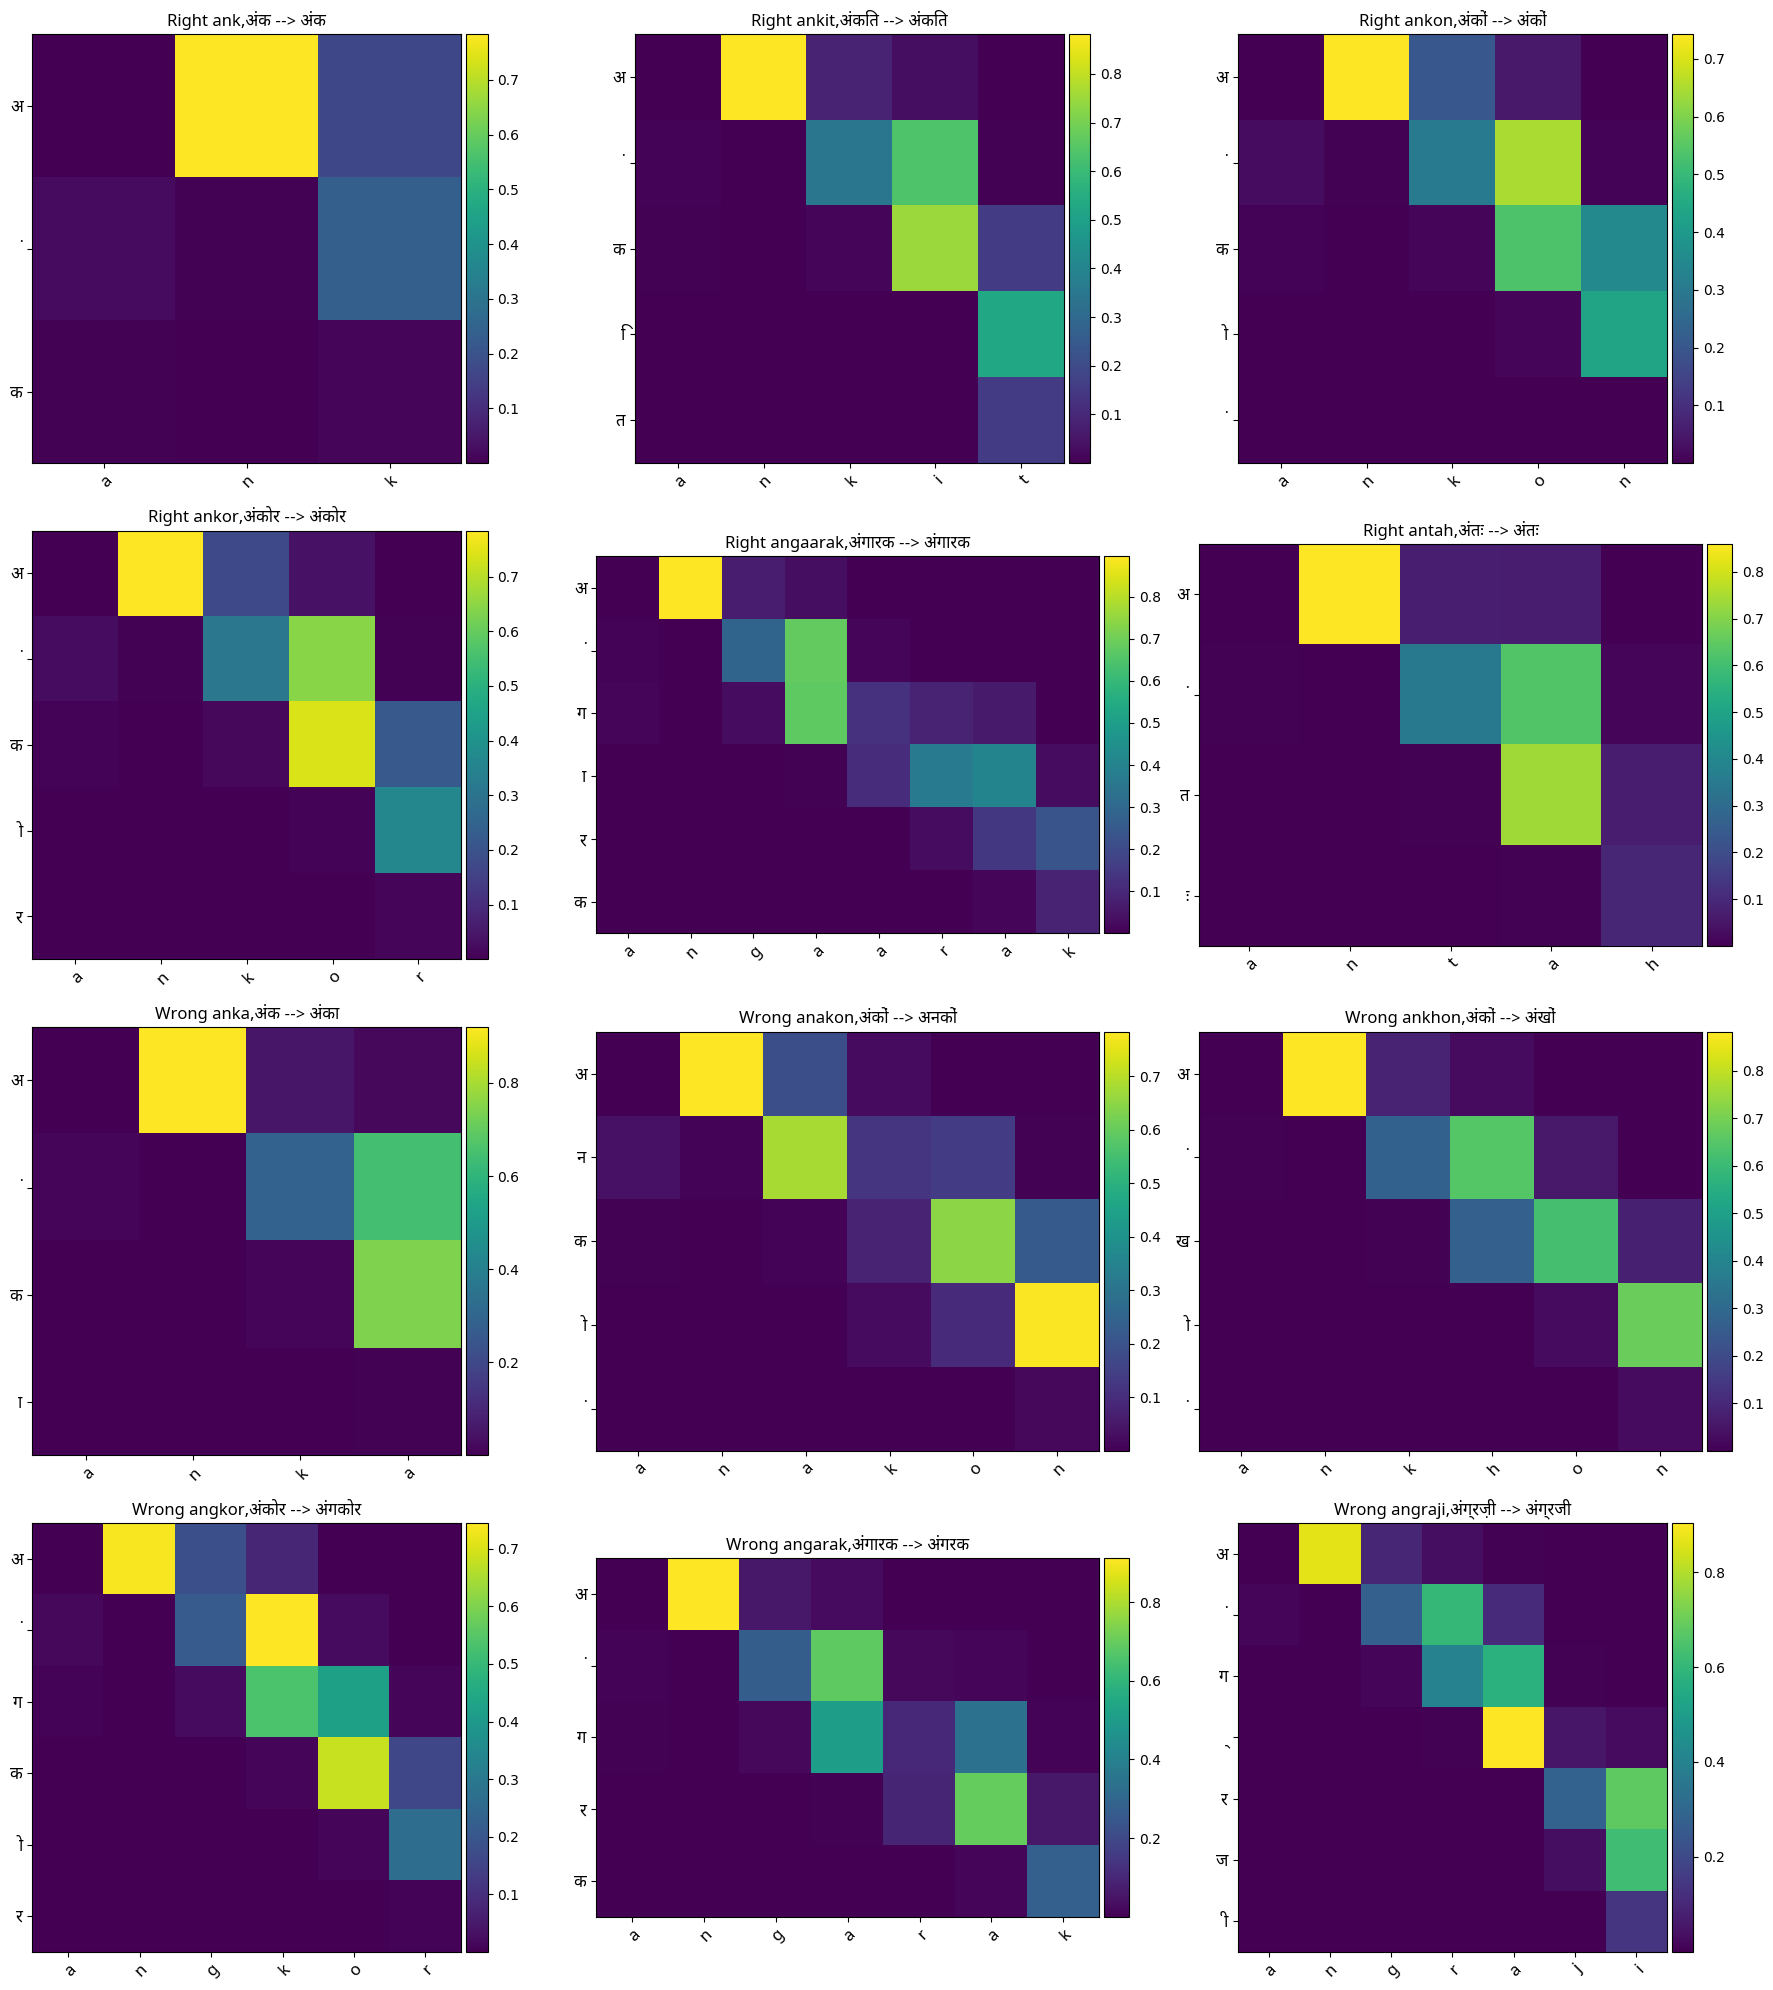

In [27]:
# Visualize attention heatmaps
print("Visualizing attention heatmaps...")
hindi_font = FontProperties(fname='/kaggle/input/ttf-fonts/NotoSansDevanagari-VariableFont_wdth,wght.ttf', size=12)
visualize_attention_heatmaps(predictions, output_dir, hindi_font)

In [43]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import wandb
import matplotlib.pyplot as plt
import numpy as np
import os
import io
from matplotlib.font_manager import FontProperties

# Visualize attention heatmaps
print("Visualizing attention heatmaps...")
hindi_font = FontProperties(fname='/kaggle/input/ttf-fonts/NotoSansDevanagari-VariableFont_wdth,wght.ttf', size=12)

def visualize_attention_heatmaps(predictions, hindi_font, num_examples=12, output_dir="/kaggle/working"):
    """
    Visualize attention heatmaps for a subset of predictions in a 4×3 grid.
    
    Args:
        predictions: List of dictionaries with predictions and attention weights
        hindi_font: Font for Hindi text
        num_examples: Number of examples to visualize
        output_dir: Directory to save output files
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Select examples to visualize (prioritize correct ones and incorrect ones)
    correct_examples = [p for p in predictions if p['is_correct']][:num_examples//2]
    incorrect_examples = [p for p in predictions if not p['is_correct']][:num_examples - len(correct_examples)]
    examples = correct_examples + incorrect_examples
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 15))
    
    for i, example in enumerate(examples):
        if i >= num_examples:
            break
        
        # Get data for this example
        source = example['source']
        target = example['target']
        prediction = example['prediction']
        attention = np.array(example['attention'])
        
        # Create subplot
        ax = fig.add_subplot(4, 3, i+1)
        
        # Plot heatmap
        im = ax.imshow(attention, cmap='viridis')
        
        # Set labels
        ax.set_xticks(range(len(source)))
        ax.set_yticks(range(len(prediction)))
        ax.set_xticklabels(list(source), fontproperties=hindi_font)
        ax.set_yticklabels(list(prediction), fontproperties=hindi_font)
        
        # Rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
        # Add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        # Set title
        correct_str = "Right" if example['is_correct'] else "Wrong"
        ax.set_title(f"{correct_str} {source} --> {prediction}", fontproperties=hindi_font)
    
    plt.tight_layout()
    
    # Save to file
    grid_path = os.path.join(output_dir, 'attention_heatmaps_grid.png')
    plt.savefig(grid_path, dpi=300, bbox_inches='tight')
    print(f"Saved heatmaps to {grid_path}")
    
    # Log to WandB - using multiple approaches for reliability
    try:
        # Ensure wandb is initialized
        if wandb.run is None:
            print("WandB run not initialized. Initializing now...")
            wandb.init(project="DA6401_Assignment_03_Attention")
            
        # Method 1: Log directly from file path
        wandb.log({"attention_heatmaps": wandb.Image(grid_path)}, commit=True)
        print("Successfully logged attention heatmaps to WandB")
        
    except Exception as e:
        print(f"Error logging to WandB via file path: {e}")
        
        try:
            # Method 2: Convert to numpy array and log
            import PIL.Image
            img_array = np.array(PIL.Image.open(grid_path))
            wandb.log({"attention_heatmaps_array": wandb.Image(img_array)}, commit=True)
            print("Successfully logged attention heatmaps as array")
            
        except Exception as e2:
            print(f"Error logging as array: {e2}")
            
            try:
                # Method 3: Log figure directly
                wandb.log({"attention_heatmaps_fig": wandb.Image(fig)}, commit=True)
                print("Successfully logged matplotlib figure directly")
                
            except Exception as e3:
                print(f"All logging methods failed. Final error: {e3}")
                import traceback
                traceback.print_exc()
    
    plt.close()
    return grid_path

# Call the function
visualize_attention_heatmaps(predictions, hindi_font)

Visualizing attention heatmaps...
Saved heatmaps to /kaggle/working/attention_heatmaps_grid.png
Successfully logged attention heatmaps to WandB


'/kaggle/working/attention_heatmaps_grid.png'

In [61]:
import wandb
import matplotlib.pyplot as plt

# Initialize wandb with your specific project name
wandb.init(project="DA6401_Assignment_03", name="attention_visualization")

# Path to your specific image
image_path = "/kaggle/working/attention_heatmaps_grid.png"

# Create figure
plt.figure(figsize=(10, 10))
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title("Attention Heatmap")

# Log the attention heatmap to wandb
wandb.log({"attention_heatmap": wandb.Image(plt)})
plt.close()  # Close figure to free memory

# Finish the run
wandb.finish()

In [53]:
import torch
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Slider, CustomJS
from bokeh.layouts import column, row
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


In [76]:
def extract_attention_weights(model, src, tgt, device):
    """
    Extract attention weights from the attention model.
    
    Args:
        model: Trained AttentionSeq2Seq model
        src: Source sequence tensor [batch_size, seq_len]
        tgt: Target sequence tensor [batch_size, seq_len]
        device: Device to run inference on
        
    Returns:
        Dictionary with attention weights and predictions
    """
    model.eval()
    batch_size = src.size(0)
    
    with torch.no_grad():
        # Generate predictions with attention weights
        predictions, attention_weights = generate_with_attention(
            model,
            src,
            max_len=tgt.size(1),
            eos_idx=3,
            sos_idx=2,
            device=device
        )
        
        return {
            'predictions': predictions.cpu().numpy(),
            'attention_weights': attention_weights.cpu().numpy(),
            'src': src.cpu().numpy(),
            'tgt': tgt.cpu().numpy()
        }

def create_index_html(output_dir):
    """
    Create an index.html file that links to all visualizations.
    
    Args:
        output_dir: Directory containing visualizations
    """
    html_files = [f for f in os.listdir(output_dir) if f.endswith('.html') and f != 'index.html']
    
    with open(os.path.join(output_dir, 'index.html'), 'w') as f:
        f.write('<!DOCTYPE html>\n<html>\n<head>\n')
        f.write('<title>Attention Connectivity Visualizations</title>\n')
        f.write('<meta charset="UTF-8">\n')
        f.write('<style>\n')
        f.write('body { font-family: Arial, sans-serif; margin: 20px; line-height: 1.6; }\n')
        f.write('h1 { color: #333; border-bottom: 2px solid #eee; padding-bottom: 10px; }\n')
        f.write('p { margin-bottom: 20px; }\n')
        f.write('ul { list-style-type: none; padding: 0; }\n')
        f.write('li { margin: 10px 0; background: #f9f9f9; padding: 10px; border-radius: 5px; }\n')
        f.write('a { color: #0066cc; text-decoration: none; font-weight: bold; }\n')
        f.write('a:hover { text-decoration: underline; }\n')
        f.write('.description { color: #666; font-style: italic; }\n')
        f.write('</style>\n')
        f.write('</head>\n<body>\n')
        f.write('<h1>Attention Connectivity Visualizations</h1>\n')
        f.write('<p>These visualizations show the attention weights between source and target characters in the transliteration model. ' +
                'The heatmap shows which input characters the model focuses on when generating each output character.</p>\n')
        f.write('<p>Each visualization includes:</p>\n')
        f.write('<ul>\n')
        f.write('<li>A heatmap showing attention weights between all characters</li>\n')
        f.write('<li>A slider to animate through the sequence generation process</li>\n')
        f.write('<li>A bar chart showing attention distribution for the current character</li>\n')
        f.write('</ul>\n')
        f.write('<p class="description">Click on a link below to view the interactive visualization:</p>\n')
        f.write('<ul>\n')
        
        for i, html_file in enumerate(sorted(html_files)):
            f.write(f'<li><a href="{html_file}" target="_blank">Example {i+1}</a> - Interactive attention visualization</li>\n')
        
        f.write('</ul>\n')
        f.write('<p class="description">Note: These visualizations require JavaScript to be enabled in your browser.</p>\n')
        f.write('</body>\n</html>')


In [77]:
def create_attention_connectivity_bokeh(src_text, tgt_text, attention_weights, output_file_path=None):
    """
    Create an interactive Bokeh visualization of attention connectivity with a 1D heatmap.
    """
    # Prepare data
    src_len = len(src_text)
    tgt_len = len(tgt_text)
    
    # Import required Bokeh components
    from bokeh.plotting import figure, output_file, save
    from bokeh.models import ColumnDataSource, HoverTool, Slider, CustomJS
    from bokeh.layouts import column
    from bokeh.palettes import Viridis256
    from bokeh.transform import linear_cmap
    from bokeh.resources import INLINE
    
    # Set up output file if provided
    if output_file_path:
        output_file(output_file_path, title="Attention Connectivity Visualization", mode='inline')
    
    # Create a color mapper for the heatmap
    mapper = linear_cmap(field_name='weight', palette=Viridis256, 
                         low=0, high=attention_weights.max())
    
    # Create data source for the 1D heatmap (initialize with first row)
    heatmap_source = ColumnDataSource(data=dict(
        x=list(range(src_len)),
        weight=attention_weights[0].tolist(),
        src_char=list(src_text)
    ))
    
    # Create figure for the 1D heatmap
    p = figure(title=f"Attention for '{tgt_text[0]}'", 
               x_range=list(src_text), y_range=(0, 1),
               width=600, height=300, tools="hover,save,pan,box_zoom,reset,wheel_zoom")
    
    # Create 1D heatmap using rect glyphs
    p.rect(x='x', y=0.5, width=0.9, height=0.8, source=heatmap_source,
           fill_color=mapper, line_color=None)
    
    # Add hover tooltip
    hover = HoverTool()
    hover.tooltips = [
        ("Source", "@src_char"),
        ("Weight", "@weight{0.000}")
    ]
    p.add_tools(hover)
    
    # Add source character labels
    p.xaxis.major_label_orientation = "vertical"
    
    # Create animation slider
    slider = Slider(start=0, end=tgt_len-1, value=0, step=1, 
                   title=f"Target Character: {tgt_text[0]}")
    
    # Convert attention weights to a list of lists for JavaScript
    attention_list = attention_weights.tolist()
    
    # Add callback for slider
    callback = CustomJS(args=dict(
        heatmap_source=heatmap_source, 
        attention=attention_list,
        tgt_text=tgt_text,
        slider=slider,
        p_title=p.title), 
    code="""
        // Get the current slider value (target character position)
        var time = slider.value;
        
        // Update the heatmap data
        var data = heatmap_source.data;
        data['weight'] = attention[time];
        
        // This is critical - emit the change event to update the visualization
        heatmap_source.change.emit();
        
        // Update the heatmap title to show which character we're generating
        var char = tgt_text[time];
        p_title.text = "Attention for '" + char + "'";
        
        // Update slider title
        slider.title = "Target Character: " + char;
    """)
    
    # Connect the callback to the slider
    slider.js_on_change('value', callback)
    
    # Create layout
    layout = column(p, slider)
    
    # Save if output file is provided
    if output_file_path:
        save(layout, filename=output_file_path, title="Attention Connectivity Visualization", resources=INLINE)
    
    return layout

In [67]:
def test_bokeh_visualization(output_dir):
    """
    Create a simple test visualization to verify Bokeh is working correctly.
    
    Args:
        output_dir: Directory to save the test visualization
    """
    from bokeh.plotting import figure, output_file, save
    from bokeh.models import ColumnDataSource
    from bokeh.resources import INLINE
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Create a simple test plot
    output_file(os.path.join(output_dir, 'test_bokeh.html'), mode='inline')
    
    # Create some test data
    x = [1, 2, 3, 4, 5]
    y = [6, 7, 2, 4, 5]
    
    # Create a figure
    p = figure(title="Bokeh Test Plot", x_axis_label='x', y_axis_label='y')
    
    # Add a line
    p.line(x, y, line_width=2)
    
    # Save the plot with inline resources
    save(p, filename=os.path.join(output_dir, 'test_bokeh.html'), resources=INLINE)
    
    print(f"Test visualization saved to {os.path.join(output_dir, 'test_bokeh.html')}")
    print("If this file shows a blank page, there may be issues with Bokeh configuration.")


In [68]:
import bokeh
test_bokeh_visualization(output_dir='/kaggle/working')

Test visualization saved to /kaggle/working/test_bokeh.html
If this file shows a blank page, there may be issues with Bokeh configuration.


In [75]:
print("Generating attention connectivity visualizations...")
visualize_attention_connectivity(attention_model, test_loader, device, src_vocab, tgt_vocab, output_dir)

# Create index.html file
create_index_html(output_dir)

Generating attention connectivity visualizations...
Generated 5 attention connectivity visualizations in predictions_attention


In [89]:
import wandb
import os

def log_html_to_wandb(html_file_path, project_name="html_q6"):
    """
    Log a single HTML file to WandB.
    
    Args:
        html_file_path: Path to the HTML file
        project_name: WandB project name
    """
    # Initialize WandB if needed
    wandb.finish()
    wandb.init(project=project_name)
    
    # Check if file exists
    if not os.path.exists(html_file_path):
        print(f"Error: HTML file not found at {html_file_path}")
        return
    
    try:
        # Open and read the HTML file
        with open(html_file_path, 'r', encoding='utf-8') as f:
            html_content = f.read()
        
        # Log the HTML content
        wandb.log({"attention_visualization": wandb.Html(html_content)})
        # Create artifact
        html_artifact = wandb.Artifact(name="attention_visualization", type="html")
        html_artifact.add_file(html_file_path)
        wandb.log_artifact(html_artifact)
        print(f"Successfully logged HTML file to WandB project: {project_name}")
    except Exception as e:
        print(f"Error logging HTML to WandB: {e}")

In [90]:
log_html_to_wandb("/kaggle/working/predictions_attention/attention_connectivity_1.html")

Successfully logged HTML file to WandB project: html_q6


In [86]:
import wandb
import os

def log_html_to_wandb(html_file_path, project_name="html_visualization"):
    """
    Log a single HTML file to WandB with proper rendering.
    
    Args:
        html_file_path: Path to the HTML file
        project_name: WandB project name
    """
    # Initialize WandB if needed
    try:
        wandb.finish()  # Close any existing runs
    except:
        pass
    
    wandb.init(project=project_name)
    
    # Check if file exists
    if not os.path.exists(html_file_path):
        print(f"Error: HTML file not found at {html_file_path}")
        return
    
    try:
        # Open and read the HTML file
        with open(html_file_path, 'r', encoding='utf-8') as f:
            html_content = f.read()
        
        # Method 1: Use wandb.Html with iframe=True option
        # This is the preferred method for rendering HTML properly
        wandb.log({"attention_visualization": wandb.Html(html_content, inject=False)})
        
        # Method 2: Save the HTML file as an artifact
        # This provides a way to download and view the HTML file directly
        html_artifact = wandb.Artifact(name="attention_visualization", type="html")
        html_artifact.add_file(html_file_path)
        wandb.log_artifact(html_artifact)
        
        print(f"Successfully logged HTML file to WandB project: {project_name}")
        print("The HTML should now be properly rendered in the WandB UI")
        print("You can also access the HTML file directly from the Artifacts tab")
        
    except Exception as e:
        print(f"Error logging HTML to WandB: {e}")
    
    # Finish the run
    wandb.finish()

# Example usage:
# log_html_to_wandb("/path/to/your/attention_visualization.html", "attention_analysis")

# If your HTML has JavaScript that needs to be executed, you might need 
# a custom HTML report in the W&B UI. Here's how to create one:

def create_custom_report_with_html(html_file_path, project_name="html_visualization"):
    """
    Creates a custom W&B report with properly rendered HTML.
    This approach works better for complex interactive visualizations.
    
    Args:
        html_file_path: Path to the HTML file
        project_name: WandB project name
    """
    try:
        wandb.finish()  # Close any existing runs
    except:
        pass
    
    run = wandb.init(project=project_name)
    
    # Check if file exists
    if not os.path.exists(html_file_path):
        print(f"Error: HTML file not found at {html_file_path}")
        return
    
    try:
        # Add the file as an artifact
        html_artifact = wandb.Artifact(name="attention_visualization", type="html")
        html_artifact.add_file(html_file_path)
        run.log_artifact(html_artifact)
        
        # Get the path where the artifact is stored
        artifact_path = html_artifact.get_path(os.path.basename(html_file_path)).download()
        
        # Create a panel in the W&B UI with custom HTML iframe
        panel_html = f"""
        <div style="width:100%; height:800px;">
            <iframe src="{artifact_path}" frameborder="0" style="width:100%; height:100%;"></iframe>
        </div>
        """
        
        # Log this panel HTML
        wandb.log({"custom_html_panel": wandb.Html(panel_html)})
        
        print("Created a custom panel with your HTML visualization.")
        print("Check the 'custom_html_panel' section in the W&B UI.")
        print("You can also find the HTML file in the Artifacts tab.")
        
    except Exception as e:
        print(f"Error creating custom report: {e}")
    
    wandb.finish()

# For very complex visualizations, you might want to create an external HTML file
# and refer to it in your W&B report:

def log_external_html_link(html_file_path, project_name="html_visualization"):
    """
    Creates a W&B report with a link to an external HTML file.
    Use this when the HTML is too complex for direct embedding.
    
    Args:
        html_file_path: Path to the HTML file
        project_name: WandB project name
    """
    try:
        wandb.finish()
    except:
        pass
    
    run = wandb.init(project=project_name)
    
    # Upload the HTML file as an artifact
    html_artifact = wandb.Artifact(name="external_html", type="html")
    html_artifact.add_file(html_file_path)
    
    # Log the artifact
    run.log_artifact(html_artifact)
    
    # Get the artifact URL
    artifact_id = html_artifact.id
    entity = wandb.run.entity
    project = wandb.run.project
    
    # Create a markdown note with instructions and link
    note = f"""
    # HTML Visualization
    
    Your HTML visualization is available as an artifact.
    
    To view it:
    1. Go to the Artifacts tab
    2. Find and download the "external_html" artifact
    3. Open the HTML file in your browser
    
    [Direct link to artifact](https://wandb.ai/{entity}/{project}/artifacts/{artifact_id})
    """
    
    wandb.run.notes.append(note)
    print("Added instructions to access the HTML file to the run notes.")
    
    wandb.finish()